# Tunable chiral metasurface based on phase change material

Chiral optical structures, characterized by their absence of mirror symmetry, interact distinctively with left circularly polarized (LCP) and right circularly polarized (RCP) light, resulting in circular dichroism (CD) responses. This phenomenon is crucial in diverse research fields, such as drug synthesis, chiral sensing, and optical communication. However, natural optical materials exhibit very weak CD due to limited chiral light-matter interaction strength. In contrast, optical metasurfaces, as artificially engineered materials, can exhibit electromagnetic properties surpassing those of natural materials. Specifically, optical metasurfaces with chiral structures as unit cells can demonstrate strong chiroptical properties with high CD. 

In this notebook, we demonstrate a wavelength-tunable infrared chiral metasurface, incorporating the phase-change material GST-225, with a parallelogram-shaped resonator as its unit cell. The metasurface's resonance wavelength is tuned through the phase transition of GST-225. The design is based on `Haotian Tang, Liliana Stan, David A. Czaplewski, Xiaodong Yang, and Jie Gao, "Wavelength-tunable infrared chiral metasurfaces with phase-change materials," Opt. Express 31, 21118-21127 (2023)` [DOI:10.1364/OE.489841](https://doi.org/10.1364/OE.489841).

<img src="img/tunable_chiral_metasurface.png" width="500" alt="Schematic of the metasurface">

For more metamaterial and metasurface examples, please see the [dielectric metasurface absorber](https://www.flexcompute.com/tidy3d/examples/notebooks/DielectricMetasurfaceAbsorber/), the [graphene metamaterial absorber](https://www.flexcompute.com/tidy3d/examples/notebooks/GrapheneMetamaterial/), the [Fano metasurface](https://www.flexcompute.com/tidy3d/examples/notebooks/HighQGe/), and the [gradient metasurface reflector](https://www.flexcompute.com/tidy3d/examples/notebooks/GradientMetasurfaceReflector/).

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tidy3d as td
import tidy3d.web as web
from tidy3d.plugins.dispersion import FastDispersionFitter, AdvancedFastFitterParam

## Simulation Setup 

In this example, we investigate the wavelength range of 2-3 µm.

In [2]:
lda0 = 2.5  # central wavelength
freq0 = td.C_0 / lda0  # central frequency
ldas = np.linspace(2, 3, 101)  # wavelength range
freqs = td.C_0 / ldas  # frequency range
fwidth = 0.5 * (np.max(freqs) - np.min(freqs))  # width of the source frequency range

### Define Geometric Parameters

The physical meaning of the parameters is schematically shown in Fig. 1(b) of the [paper](https://doi.org/10.1364/OE.489841).

In [3]:
Px = 1.25  # unit cell period in the x direction
Py = 0.4  # unit cell period in the y direction
A = 0.24  # width of the Al resonator
B = 0.21  # width of the slot
alpha = 30 * np.pi / 180  # tilted angle of the slot
t_gst = 0.075  # thickness of the GST layer
t_al2o3 = 0.025  # thickness of the Al2O3 capping layer
t_al = 0.06  # thickness of the Al layer

### Define Material Media

For aluminum, we directly use the predefined medium from the [material library](../material_library.html). Alumina is defined by a [Sellmeier](../_autosummary/tidy3d.Sellmeier.html) model.  

In [4]:
Al = td.material_library["Al"]["RakicLorentzDrude1998"]

coeffs = [(1.431, 0.0727**2), (0.651, 0.119**2), (5.341, 18.028**2)]
Al2O3 = td.Sellmeier(coeffs=coeffs)

The crystalline and amorphous states of GST are defined by using the [FastDispersionFitter](../_autosummary/tidy3d.plugins.dispersion.FastDispersionFitter.html) to fit wavelength-dependent refractive index profiles stored in CSV files.

Output()

[11:00:08] WARNING: Unable to fit with weighted RMS error under 'tolerance_rms' 
           of 0.05                                                              

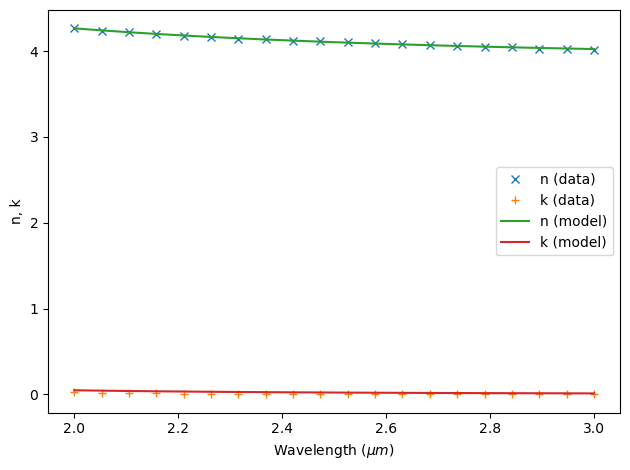

In [5]:
fitter = FastDispersionFitter.from_file("misc/GST_A_nk.csv", skiprows=0, delimiter=",")
advanced_param = AdvancedFastFitterParam(weights=(1, 1))
GST_A, _ = fitter.fit(max_num_poles=4, advanced_param=advanced_param, tolerance_rms=0.05)
fitter.plot(GST_A)
plt.show()

Output()

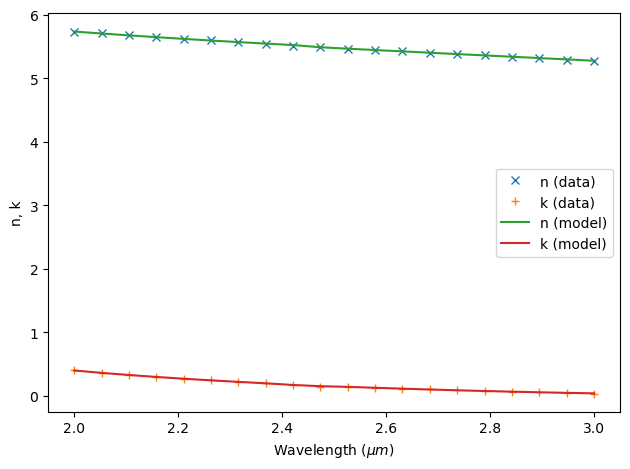

In [6]:
fitter = FastDispersionFitter.from_file("misc/GST_C_nk.csv", skiprows=0, delimiter=",")
GST_C, _ = fitter.fit(max_num_poles=4, advanced_param=advanced_param, tolerance_rms=0.05)
fitter.plot(GST_C)
plt.show()

### Define Structures in the Unit Cell

The unit cell includes a 200 nm-thick aluminum mirror layer on a silicon substrate, followed by a 75 nm GST-225 spacer layer. Above this, there is a 25 nm-thick alumina capping layer, and the assembly is topped with a 60 nm-thick aluminum layer, patterned into parallelogram-shaped resonators. The resonators are defined as [PolySlabs](../_autosummary/tidy3d.PolySlab.html) with calculated vertices. Since we need to simulate the metasurface with the GST in two states, we define a `make_gst_layer(state)` function to construct the GST layer given the state.

In [7]:
inf_eff = 1e2  # effective infinity

# calculate the vertices of the resonator on the left
vertices = [
    (-inf_eff, A / 2),
    (-inf_eff, -A / 2),
    (-(B / np.cos(alpha) + A * np.tan(alpha)) / 2, -A / 2),
    (-(B / np.cos(alpha) - A * np.tan(alpha)) / 2, A / 2),
]

# define the left resonator structure
left_resonator = td.Structure(
    geometry=td.PolySlab(vertices=vertices, axis=2, slab_bounds=(0, t_al)), medium=Al
)

# calculate the vertices of the resonator on the right
vertices = [
    (inf_eff, A / 2),
    (inf_eff, -A / 2),
    ((B / np.cos(alpha) - A * np.tan(alpha)) / 2, -A / 2),
    ((B / np.cos(alpha) + A * np.tan(alpha)) / 2, A / 2),
]

# define the right resonator structure
right_resonator = td.Structure(
    geometry=td.PolySlab(vertices=vertices, axis=2, slab_bounds=(0, t_al)), medium=Al
)

# define the Al2O3 buffer layer
buffer_layer = td.Structure(
    geometry=td.Box(center=(0, 0, -t_al2o3 / 2), size=(td.inf, td.inf, t_al2o3)), medium=Al2O3
)

# define a function to construct the GST layer given the state
def make_gst_layer(state):
    if state == "amorphous":
        medium = GST_A
    elif state == "crystalline":
        medium = GST_C
    else:
        raise ValueError("state must be `amorphous` or `crystalline`")

    gst_layer = td.Structure(
        geometry=td.Box(center=(0, 0, -t_al2o3 - t_gst / 2), size=(td.inf, td.inf, t_gst)),
        medium=medium,
    )
    return gst_layer


# define the Al substrate
al_substrate = td.Structure(
    geometry=td.Box.from_bounds(
        rmin=(-inf_eff, -inf_eff, -inf_eff), rmax=(inf_eff, inf_eff, -t_al2o3 - t_gst)
    ),
    medium=Al,
)

### Define Source and Monitors

A circularly polarized plane wave is just two perpendicularly linearly polarized plane waves with a 90 degree phase difference. Here we define a `circular_polarized_plane_wave(pol)` function to construct the circularly polarized plane wave given the polarization, either left or right.

Since the metasurface is fabricated on a metal mirror, the transmission will be zero. We only need to define a [FluxMonitor](../_autosummary/tidy3d.FluxMonitor.html) to measure reflection ($R$). Absorption can be calculated simply by $A=1-R$. To further inspect the resonant field patterns, we define two [FieldMonitors](../_autosummary/tidy3d.FieldMonitor.html) in the $xz$ and $xy$ planes. To reduce the result data size, we only record fields at the resonant wavelength when GST is in the amorphous state, which is predetermined to be 2.4 µm.

In [8]:
def circular_polarized_plane_wave(pol):
    # define a plane wave polarized in the x direction
    plane_wave_x = td.PlaneWave(
        source_time=td.GaussianPulse(freq0=freq0, fwidth=fwidth),
        size=(td.inf, td.inf, 0),
        center=(0, 0, 0.3 * lda0),
        direction="-",
        pol_angle=0,
    )
    
    # determine the phase difference given the polarization
    if pol == "left":
        phase = -np.pi / 2
    elif pol == "right":
        phase = np.pi / 2
    else:
        raise ValueError("pol must be `left` or `right`")
    
    # define a plane wave polarized in the y direction with a phase difference
    plane_wave_y = td.PlaneWave(
        source_time=td.GaussianPulse(freq0=freq0, fwidth=fwidth, phase=phase),
        size=(td.inf, td.inf, 0),
        center=(0, 0, 0.3 * lda0),
        direction="-",
        pol_angle=np.pi / 2,
    )

    return [plane_wave_x, plane_wave_y]


# add a flux monitor to detect transmission
monitor_r = td.FluxMonitor(
    center=[0, 0, 0.5 * lda0], size=[td.inf, td.inf, 0], freqs=freqs, name="R"
)

freq_res = td.C_0 / 2.4 # resonant frequency

# add field monitors to see the field profiles at the absorption peak frequency when GST is in the amorphous state
monitor_field_xz = td.FieldMonitor(
    center=(0, 0, 0), size=(td.inf, 0, td.inf), freqs=[freq_res], name="field_xz"
)

monitor_field_xy = td.FieldMonitor(
    center=(0, 0, 0), size=(td.inf, td.inf, 0), freqs=[freq_res], name="field_xy"
)

[11:00:10] WARNING: Default value for the field monitor 'colocate' setting has  
           changed to 'True' in Tidy3D 2.4.0. All field components will be      
           colocated to the grid boundaries. Set to 'False' to get the raw      
           fields on the Yee grid instead.                                      

           WARNING: Default value for the field monitor 'colocate' setting has  
           changed to 'True' in Tidy3D 2.4.0. All field components will be      
           colocated to the grid boundaries. Set to 'False' to get the raw      
           fields on the Yee grid instead.                                      

### Define Simulation

Now we are ready to set up the simulation. In total we need to run four simulations to cover both polarizations and GST states. To make it more convenient, we define a `make_sim(pol, state)` function.

In [9]:
run_time = 3e-13  # simulation run time

# simulation domain box
sim_box = td.Box.from_bounds(
    rmin=(-Px / 2, -Py / 2, -t_al2o3 - t_gst - lda0 / 2), rmax=(Px / 2, Py / 2, t_al + lda0 / 2)
)

# define a function to construct a simulation given the polarization and GST state
def make_sim(pol, state):
    sim = td.Simulation(
        center=sim_box.center,
        size=sim_box.size,
        grid_spec=td.GridSpec.auto(min_steps_per_wvl=20, wavelength=lda0),
        structures=[
            left_resonator,
            right_resonator,
            buffer_layer,
            make_gst_layer(state),
            al_substrate,
        ],
        sources=circular_polarized_plane_wave(pol),
        monitors=[monitor_r, monitor_field_xz, monitor_field_xy],
        run_time=run_time,
        boundary_spec=td.BoundarySpec(
            x=td.Boundary.periodic(), y=td.Boundary.periodic(), z=td.Boundary.pml()
        ),
    )
    return sim


# make one simulation and plot it to inspect
sim_left_A = make_sim("left", "amorphous")
sim_left_A.plot_3d()

In addition, we can inspect the grid to ensure it is sufficiently fine.

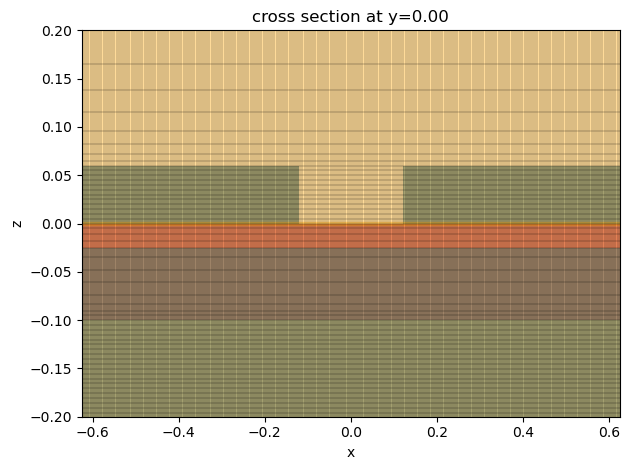

In [10]:
ax = sim_left_A.plot(y=0)
sim_left_A.plot_grid(y=0, ax=ax)
ax.set_ylim(-0.1, 0.1)
ax.set_ylim(-0.2, 0.2)
ax.set_aspect("auto")

### Run Simulation Batch

To make the simulations more efficient, we define a [Batch](../_autosummary/tidy3d.web.Batch.html) and submit it to run all four simulations in parallel. 

In [11]:
# define four simulations
sims = {
    "LCP_A": sim_left_A,
    "LCP_C": make_sim("left", "crystalline"),
    "RCP_A": make_sim("right", "amorphous"),
    "RCP_C": make_sim("right", "crystalline"),
}

# create a batch and run all sims in parallel
batch = web.Batch(simulations=sims)
batch_results = batch.run(path_dir="data")

[11:00:11] Created task 'LCP_A' with task_id                                    
           'fdve-e17dcdf5-1304-490c-9588-3b73ad22e767'.

           View task using web UI at                                            
           ]8;id=194410;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e17dcdf5-1304-490c-9588-3b73ad22e767\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=340896;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e17dcdf5-1304-490c-9588-3b73ad22e767\taskId]8;;\]8;id=194410;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e17dcdf5-1304-490c-9588-3b73ad22e767\=]8;;\]8;id=130305;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e17dcdf5-1304-490c-9588-3b73ad22e767\fdve]8;;\]8;id=194410;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e17dcdf5-1304-490c-9588-3b73ad22e767\-e17dcdf5-1304-]8;;\
           ]8;id=194410;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e17dcdf5-1304-490c-9588-3b73ad22e767\490c-9588-3b73ad22e767']8;;\.

Output()

[11:00:12] Created task 'LCP_C' with task_id                                    
           'fdve-856e20a7-57ad-4dda-b52c-59002a7ff7c7'.

           View task using web UI at                                            
           ]8;id=979626;https://tidy3d.simulation.cloud/workbench?taskId=fdve-856e20a7-57ad-4dda-b52c-59002a7ff7c7\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=697772;https://tidy3d.simulation.cloud/workbench?taskId=fdve-856e20a7-57ad-4dda-b52c-59002a7ff7c7\taskId]8;;\]8;id=979626;https://tidy3d.simulation.cloud/workbench?taskId=fdve-856e20a7-57ad-4dda-b52c-59002a7ff7c7\=]8;;\]8;id=476777;https://tidy3d.simulation.cloud/workbench?taskId=fdve-856e20a7-57ad-4dda-b52c-59002a7ff7c7\fdve]8;;\]8;id=979626;https://tidy3d.simulation.cloud/workbench?taskId=fdve-856e20a7-57ad-4dda-b52c-59002a7ff7c7\-856e20a7-57ad-]8;;\
           ]8;id=979626;https://tidy3d.simulation.cloud/workbench?taskId=fdve-856e20a7-57ad-4dda-b52c-59002a7ff7c7\4dda-b52c-59002a7ff7c7']8;;\.

Output()

           Created task 'RCP_A' with task_id                                    
           'fdve-08307142-1135-4c42-9a46-2e7709c80479'.

           View task using web UI at                                            
           ]8;id=819493;https://tidy3d.simulation.cloud/workbench?taskId=fdve-08307142-1135-4c42-9a46-2e7709c80479\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=744733;https://tidy3d.simulation.cloud/workbench?taskId=fdve-08307142-1135-4c42-9a46-2e7709c80479\taskId]8;;\]8;id=819493;https://tidy3d.simulation.cloud/workbench?taskId=fdve-08307142-1135-4c42-9a46-2e7709c80479\=]8;;\]8;id=563689;https://tidy3d.simulation.cloud/workbench?taskId=fdve-08307142-1135-4c42-9a46-2e7709c80479\fdve]8;;\]8;id=819493;https://tidy3d.simulation.cloud/workbench?taskId=fdve-08307142-1135-4c42-9a46-2e7709c80479\-08307142-1135-]8;;\
           ]8;id=819493;https://tidy3d.simulation.cloud/workbench?taskId=fdve-08307142-1135-4c42-9a46-2e7709c80479\4c42-9a46-2e7709c80479']8;;\.

Output()

[11:00:13] Created task 'RCP_C' with task_id                                    
           'fdve-e49b61cc-8049-4a39-90cc-7d49004bb27f'.

           View task using web UI at                                            
           ]8;id=741975;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e49b61cc-8049-4a39-90cc-7d49004bb27f\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=178693;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e49b61cc-8049-4a39-90cc-7d49004bb27f\taskId]8;;\]8;id=741975;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e49b61cc-8049-4a39-90cc-7d49004bb27f\=]8;;\]8;id=652936;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e49b61cc-8049-4a39-90cc-7d49004bb27f\fdve]8;;\]8;id=741975;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e49b61cc-8049-4a39-90cc-7d49004bb27f\-e49b61cc-8049-]8;;\
           ]8;id=741975;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e49b61cc-8049-4a39-90cc-7d49004bb27f\4a39-90cc-7d49004bb27f']8;;\.

Output()

[11:00:22] Started working on Batch.

[11:00:24] Maximum FlexCredit cost: 1.207 for the whole batch. Use              
           'Batch.real_cost()' to get the billed FlexCredit cost after the Batch
           has completed.

Output()

[11:05:37] Batch complete.

## Result Analysis

After the simulations are complete, we can extract the absorption spectra for all simulations.

Output()

[11:05:43] loading SimulationData from                                          
           data\fdve-e17dcdf5-1304-490c-9588-3b73ad22e767.hdf5

Output()

[11:05:45] loading SimulationData from                                          
           data\fdve-856e20a7-57ad-4dda-b52c-59002a7ff7c7.hdf5

Output()

[11:05:47] loading SimulationData from                                          
           data\fdve-08307142-1135-4c42-9a46-2e7709c80479.hdf5

Output()

[11:05:49] loading SimulationData from                                          
           data\fdve-e49b61cc-8049-4a39-90cc-7d49004bb27f.hdf5

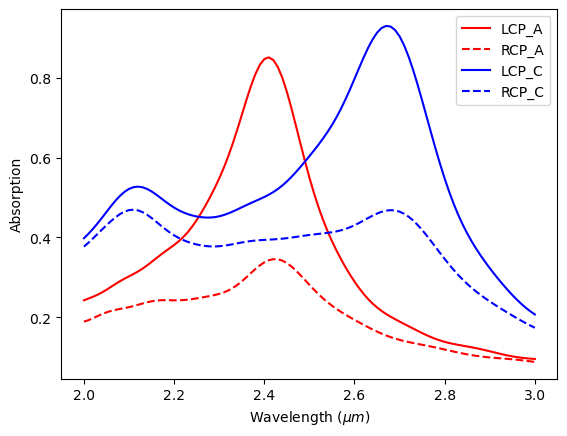

In [12]:
# extract absorption from four simulations
A_LCP_A = 1 - batch_results["LCP_A"]["R"].flux / 2
A_LCP_C = 1 - batch_results["LCP_C"]["R"].flux / 2
A_RCP_A = 1 - batch_results["RCP_A"]["R"].flux / 2
A_RCP_C = 1 - batch_results["RCP_C"]["R"].flux / 2

# plot absorption spectra
plt.plot(ldas, A_LCP_A, "red", label="LCP_A")
plt.plot(ldas, A_RCP_A, "red", linestyle="--", label="RCP_A")
plt.plot(ldas, A_LCP_C, "blue", label="LCP_C")
plt.plot(ldas, A_RCP_C, "blue", linestyle="--", label="RCP_C")
plt.ylabel("Absorption")
plt.xlabel("Wavelength ($\mu m$)")
plt.legend()
plt.show()

With the absorption spectra, we can further calculate CD for both GST states. Note that compared to the [publication](), the results are similar but not identical, which is likely due to the slightly different refractive indices for the materials.

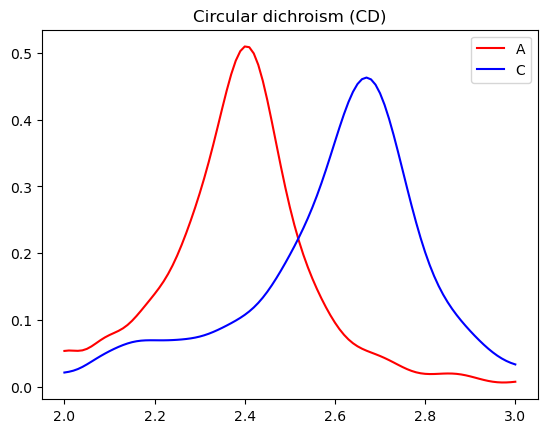

In [13]:
# plot CD spectra
plt.plot(ldas, A_LCP_A - A_RCP_A, "red", label="A")
plt.plot(ldas, A_LCP_C - A_RCP_C, "blue", label="C")
plt.title("Circular dichroism (CD)")
plt.legend()
plt.show()

Lastly, we can plot the field distributions at the resonant wavelength when GST is in the amorphous state to visualize the resonant mode. We can see that with the left circularly polarized incident, the response is much stronger, leading to a much higher absorption as seen above.

           loading SimulationData from                                          
           data\fdve-e17dcdf5-1304-490c-9588-3b73ad22e767.hdf5

[11:05:50] loading SimulationData from                                          
           data\fdve-08307142-1135-4c42-9a46-2e7709c80479.hdf5

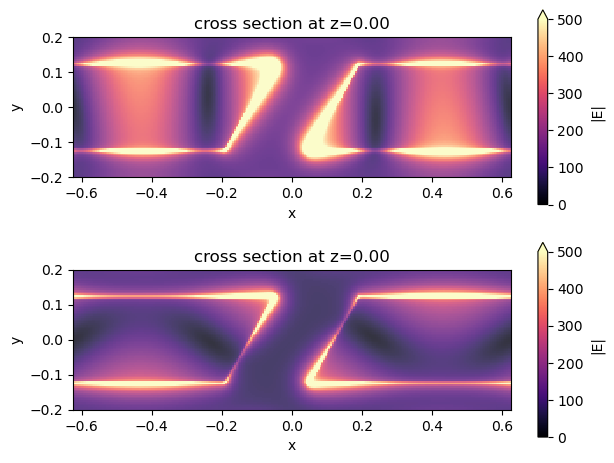

In [14]:
fig, ax = plt.subplots(2, 1, tight_layout=True)
batch_results["LCP_A"].plot_field(field_monitor_name="field_xy", field_name="E", val="abs", vmin=0, vmax=500, ax=ax[0])
batch_results["RCP_A"].plot_field(field_monitor_name="field_xy", field_name="E", val="abs", vmin=0, vmax=500, ax=ax[1])
plt.show()

Similarly, plot the field distributions in the $xz$ plane.

           loading SimulationData from                                          
           data\fdve-e17dcdf5-1304-490c-9588-3b73ad22e767.hdf5

[11:05:51] loading SimulationData from                                          
           data\fdve-08307142-1135-4c42-9a46-2e7709c80479.hdf5

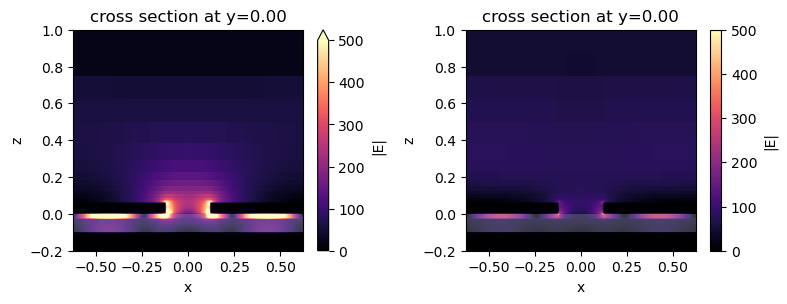

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(8, 3), tight_layout=True)
batch_results["LCP_A"].plot_field(field_monitor_name="field_xz", field_name="E", val="abs", vmin=0, vmax=500, ax=ax[0])
ax[0].set_ylim(-0.2, 1)
batch_results["RCP_A"].plot_field(field_monitor_name="field_xz", field_name="E", val="abs", vmin=0, vmax=500, ax=ax[1])
ax[1].set_ylim(-0.2, 1)
plt.show()